# SEO ~ Human German Translation of Hotel Reviews

## Setup

In [83]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
%pylab inline 
matplotlib.pyplot.style.use = 'default'
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/devonpohl/public/master/data.csv")

Populating the interactive namespace from numpy and matplotlib


## Data Exploration

Locations in the dataset:
3-partial    575
4-full       501
3-full        57
2-full         9
Name: newtrans, dtype: int64
Note that 2 corresponds to high quality, 3 to low quality, and 4 to machine translation (no change)

Locations in the dataset:
Caribbean                      370
New York City                  228
Hawaii                         101
Miami                          101
San Francisco/Northern Cali    100
Los Angeles                     76
Las Vegas                       71
Washington D.C.                 56
Boston                          39
Name: location, dtype: int64 

Ratings in the dataset:
40.0    321
35.0    283
30.0    264
45.0    132
50.0     61
25.0     60
20.0     17
15.0      2
10.0      1
Name: rating, dtype: int64 

Months when translations occurred in the dataset:
52015    1115
12016      27
Name: transmonth, dtype: int64 

Dependent variable is highly skewed:


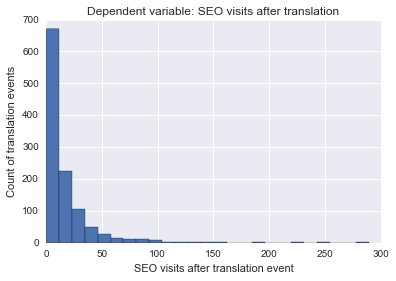

In [84]:
translations = data.newtrans.value_counts()
locations = data.location.value_counts()
ratings = data.rating.value_counts()
transmonths = data.transmonth.value_counts()
print "Locations in the dataset:\n",translations
print "Note that 2 corresponds to high quality, 3 to low quality, and 4 to machine translation (no change)\n"
print "Locations in the dataset:\n",locations ,"\n"
print "Ratings in the dataset:\n",ratings,"\n"
print "Months when translations occurred in the dataset:\n",transmonths,"\n"

print "Dependent variable is highly skewed:"
data.newvisits.hist(bins = 25)
plt.title("Dependent variable: SEO visits after translation")
plt.ylabel("Count of translation events")
plt.xlabel("SEO visits after translation event")


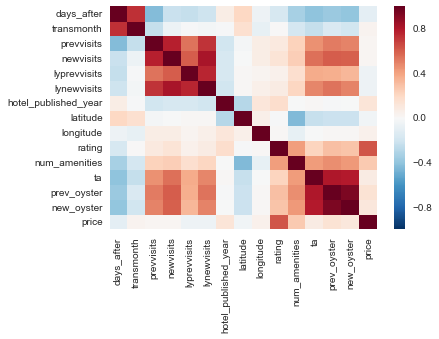

In [85]:
sns.heatmap(data.corr())

Scatterplots between some numeric dimensions of interest:


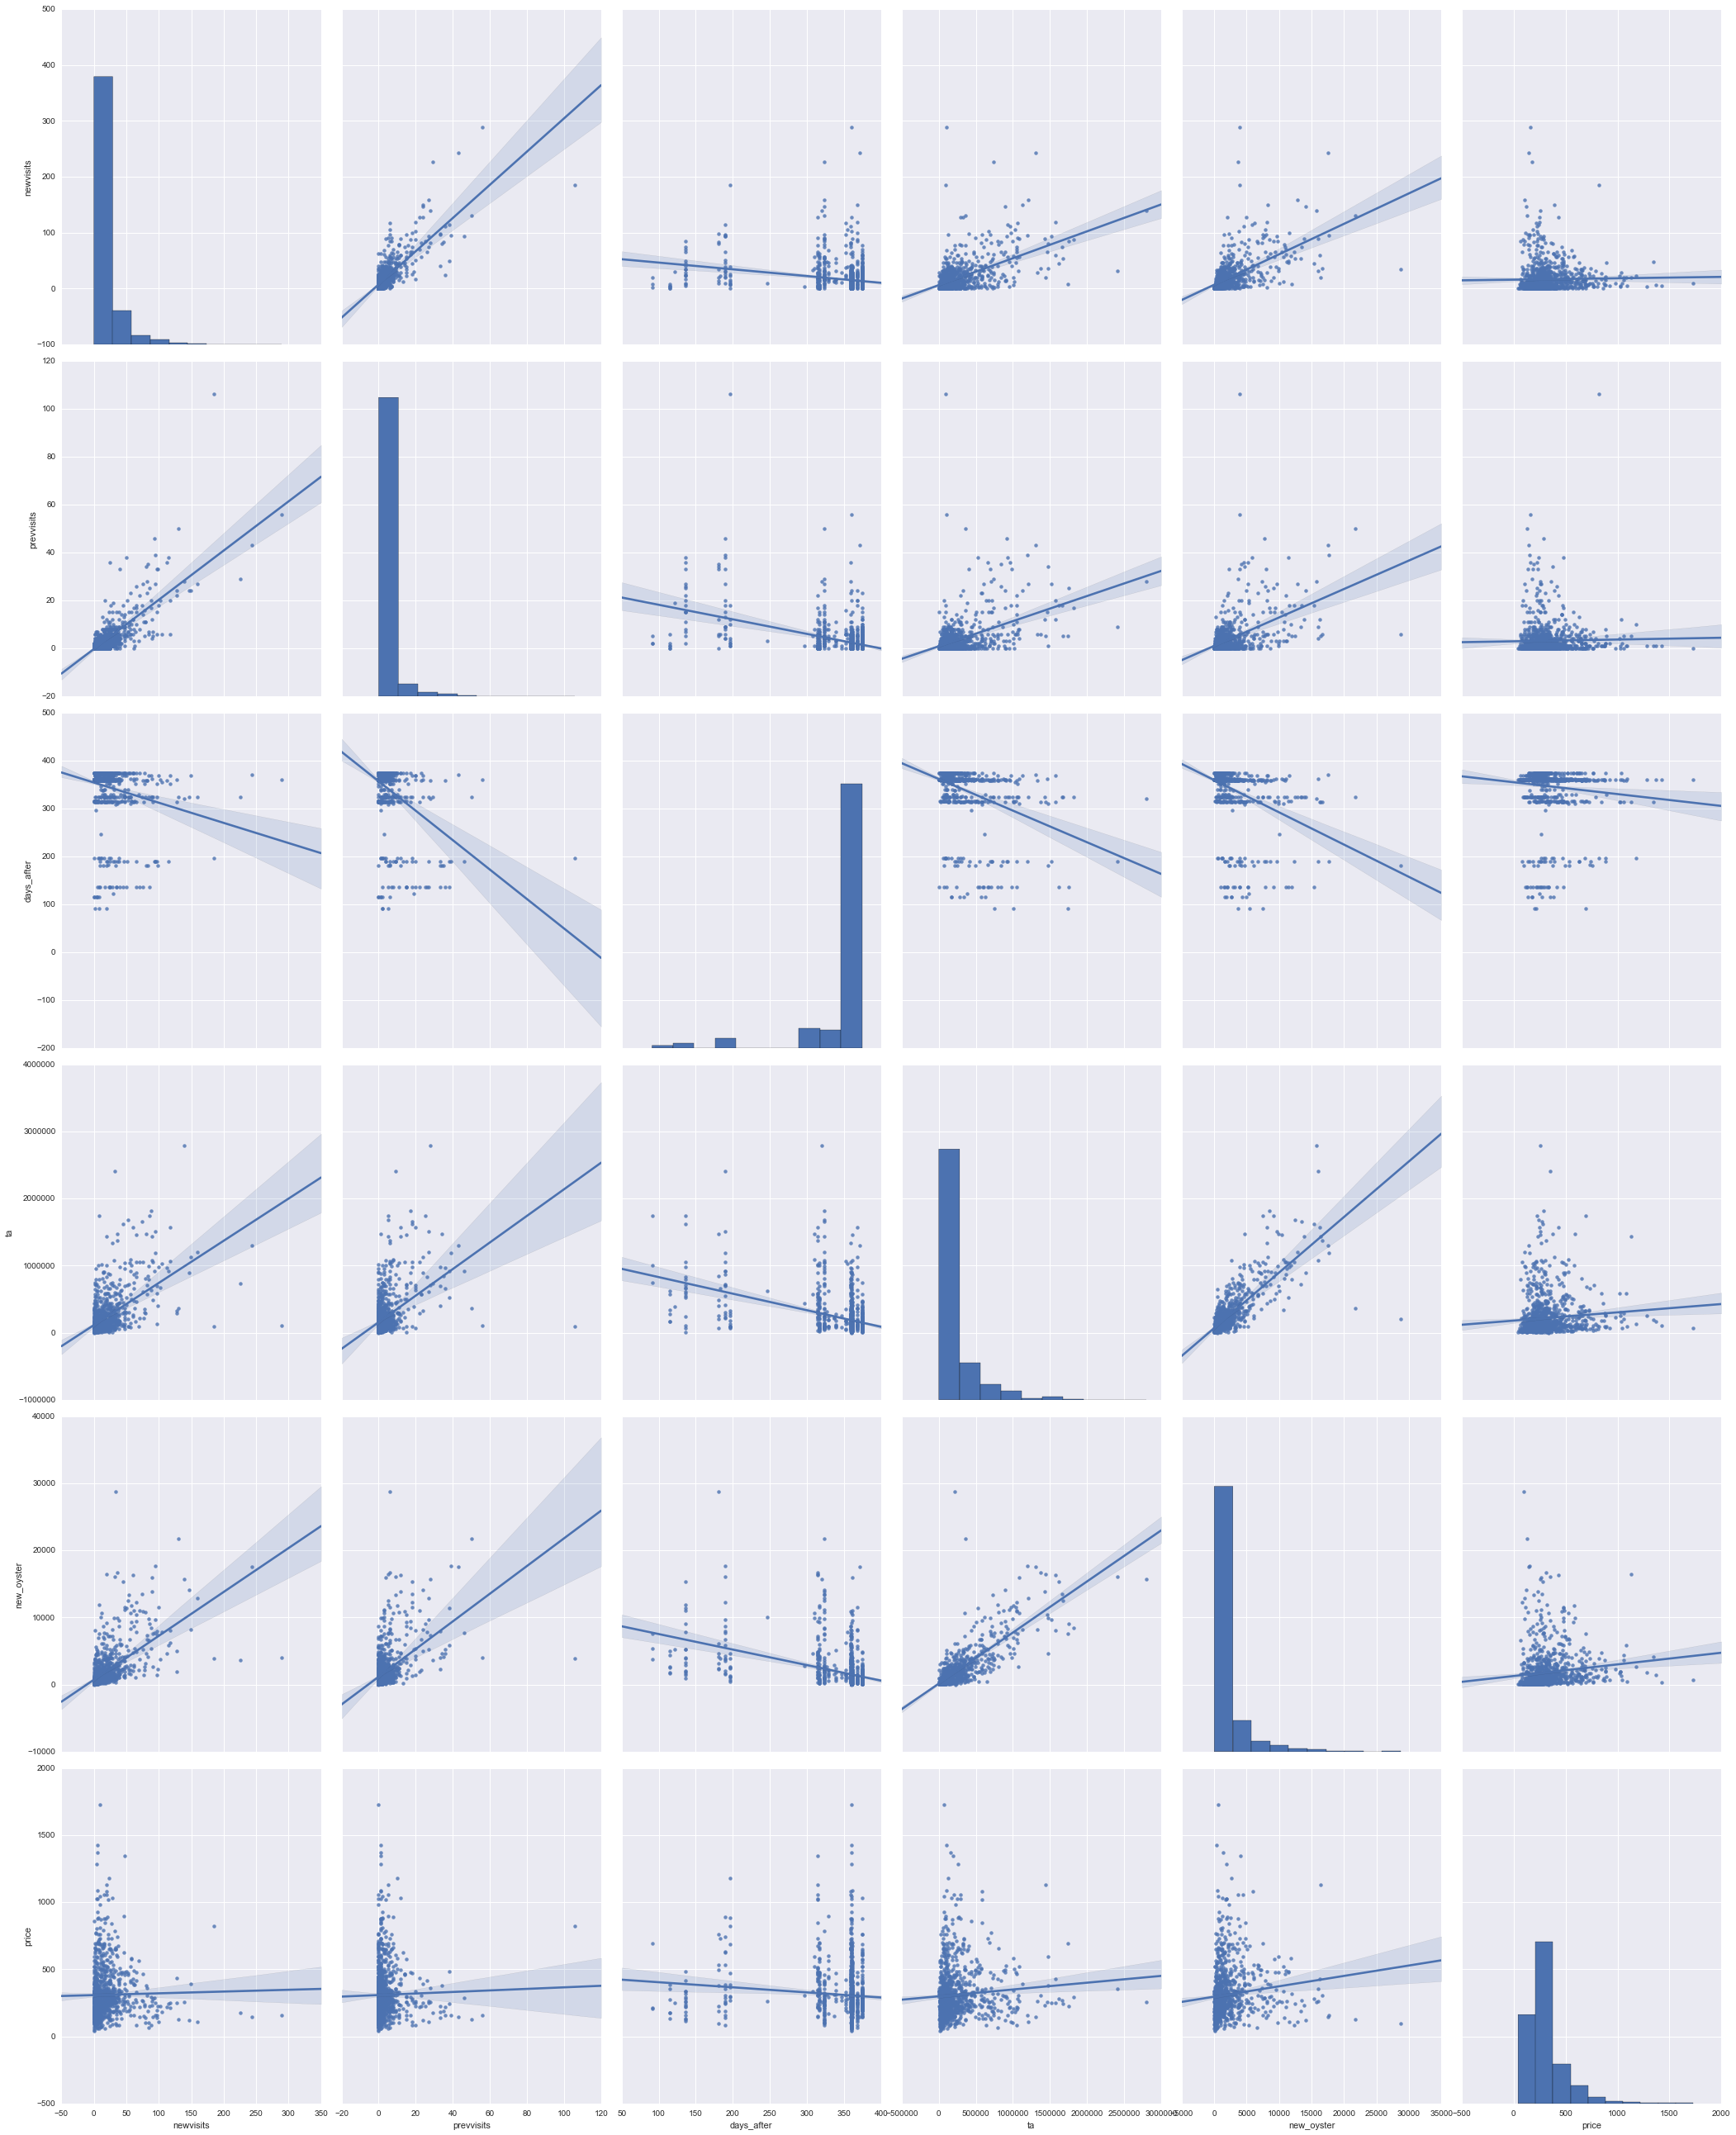

In [86]:
print "Scatterplots between some numeric dimensions of interest:"
sns.pairplot(data[['newvisits','prevvisits','days_after','ta','new_oyster','price']], size = 6, aspect = 0.8, kind = 'reg')

What we've learned so far:
- Several variables are skewed
- Few high quality human translations, may want to exclude from model
- Few very lowly rated hotels in dataset, may want to group into lower quality factor dimension
- 'visits' dimensions are higly correlated. This is expected - the purpose of this model is to understand how translation affects new visits given trend/seasonal data which is hopefully captured in the vistis dimensions.
- 'ta' and oyster dimensions are strongly correlated with one another and reasonably strongly with the visits dimensions. Visits dimensions are visits on the DE site, while ta and oyster dimensions are indices related to traffic on all domains. Hopefully these dimensions contain useful data regarding which hotels stand to gain from translation.

## Transform to adjust for skew; try pair plots again

In [107]:
num_data = data[['newvisits','prevvisits','lynewvisits','lyprevvisits','longitude','latitude',
          'days_after','ta','prev_oyster','new_oyster','price']]

all_skews = num_data.apply(stats.skew,axis=0)
print all_skews,"\n"  
skew_check = pd.DataFrame(all_skews[np.abs(all_skews) > 1.2])
skewed_cols = skew_check.index.tolist()
print "Skewed columns: ", skewed_cols

transformed = data[skewed_cols].apply(lambda x: stats.boxcox(x + .001)[0], axis = 0)
non_transformed = num_data.ix[:,~num_data.columns.isin(skewed_cols)]

numeric = pd.concat([transformed,non_transformed], axis = 1)

newvisits       4.140199
prevvisits      6.133247
lynewvisits     5.223731
lyprevvisits    8.788076
longitude      -0.956458
latitude       -0.166202
days_after     -3.535471
ta              3.255874
prev_oyster     3.132006
new_oyster      3.602211
price           2.377889
dtype: float64 

Skewed columns:  ['newvisits', 'prevvisits', 'lynewvisits', 'lyprevvisits', 'days_after', 'ta', 'prev_oyster', 'new_oyster', 'price']
   newvisits  prevvisits  lynewvisits  lyprevvisits    days_after         ta  \
0   2.971781   -4.822805     0.753766      1.149895  1.438729e+23  11.335039   
1   2.002670    0.001000     0.001000     -5.276074  1.438729e+23  11.719316   
2   2.287446    0.001000     0.753766     -5.276074  1.438729e+23  12.207896   
3   6.711026    0.001000     1.254920      1.720507  3.957918e+22  12.396963   
4   1.672172    0.001000     1.254920      0.001000  1.438729e+23  12.656618   

   prev_oyster  new_oyster     price   longitude   latitude  
0    11.445701    8.965218  5.9

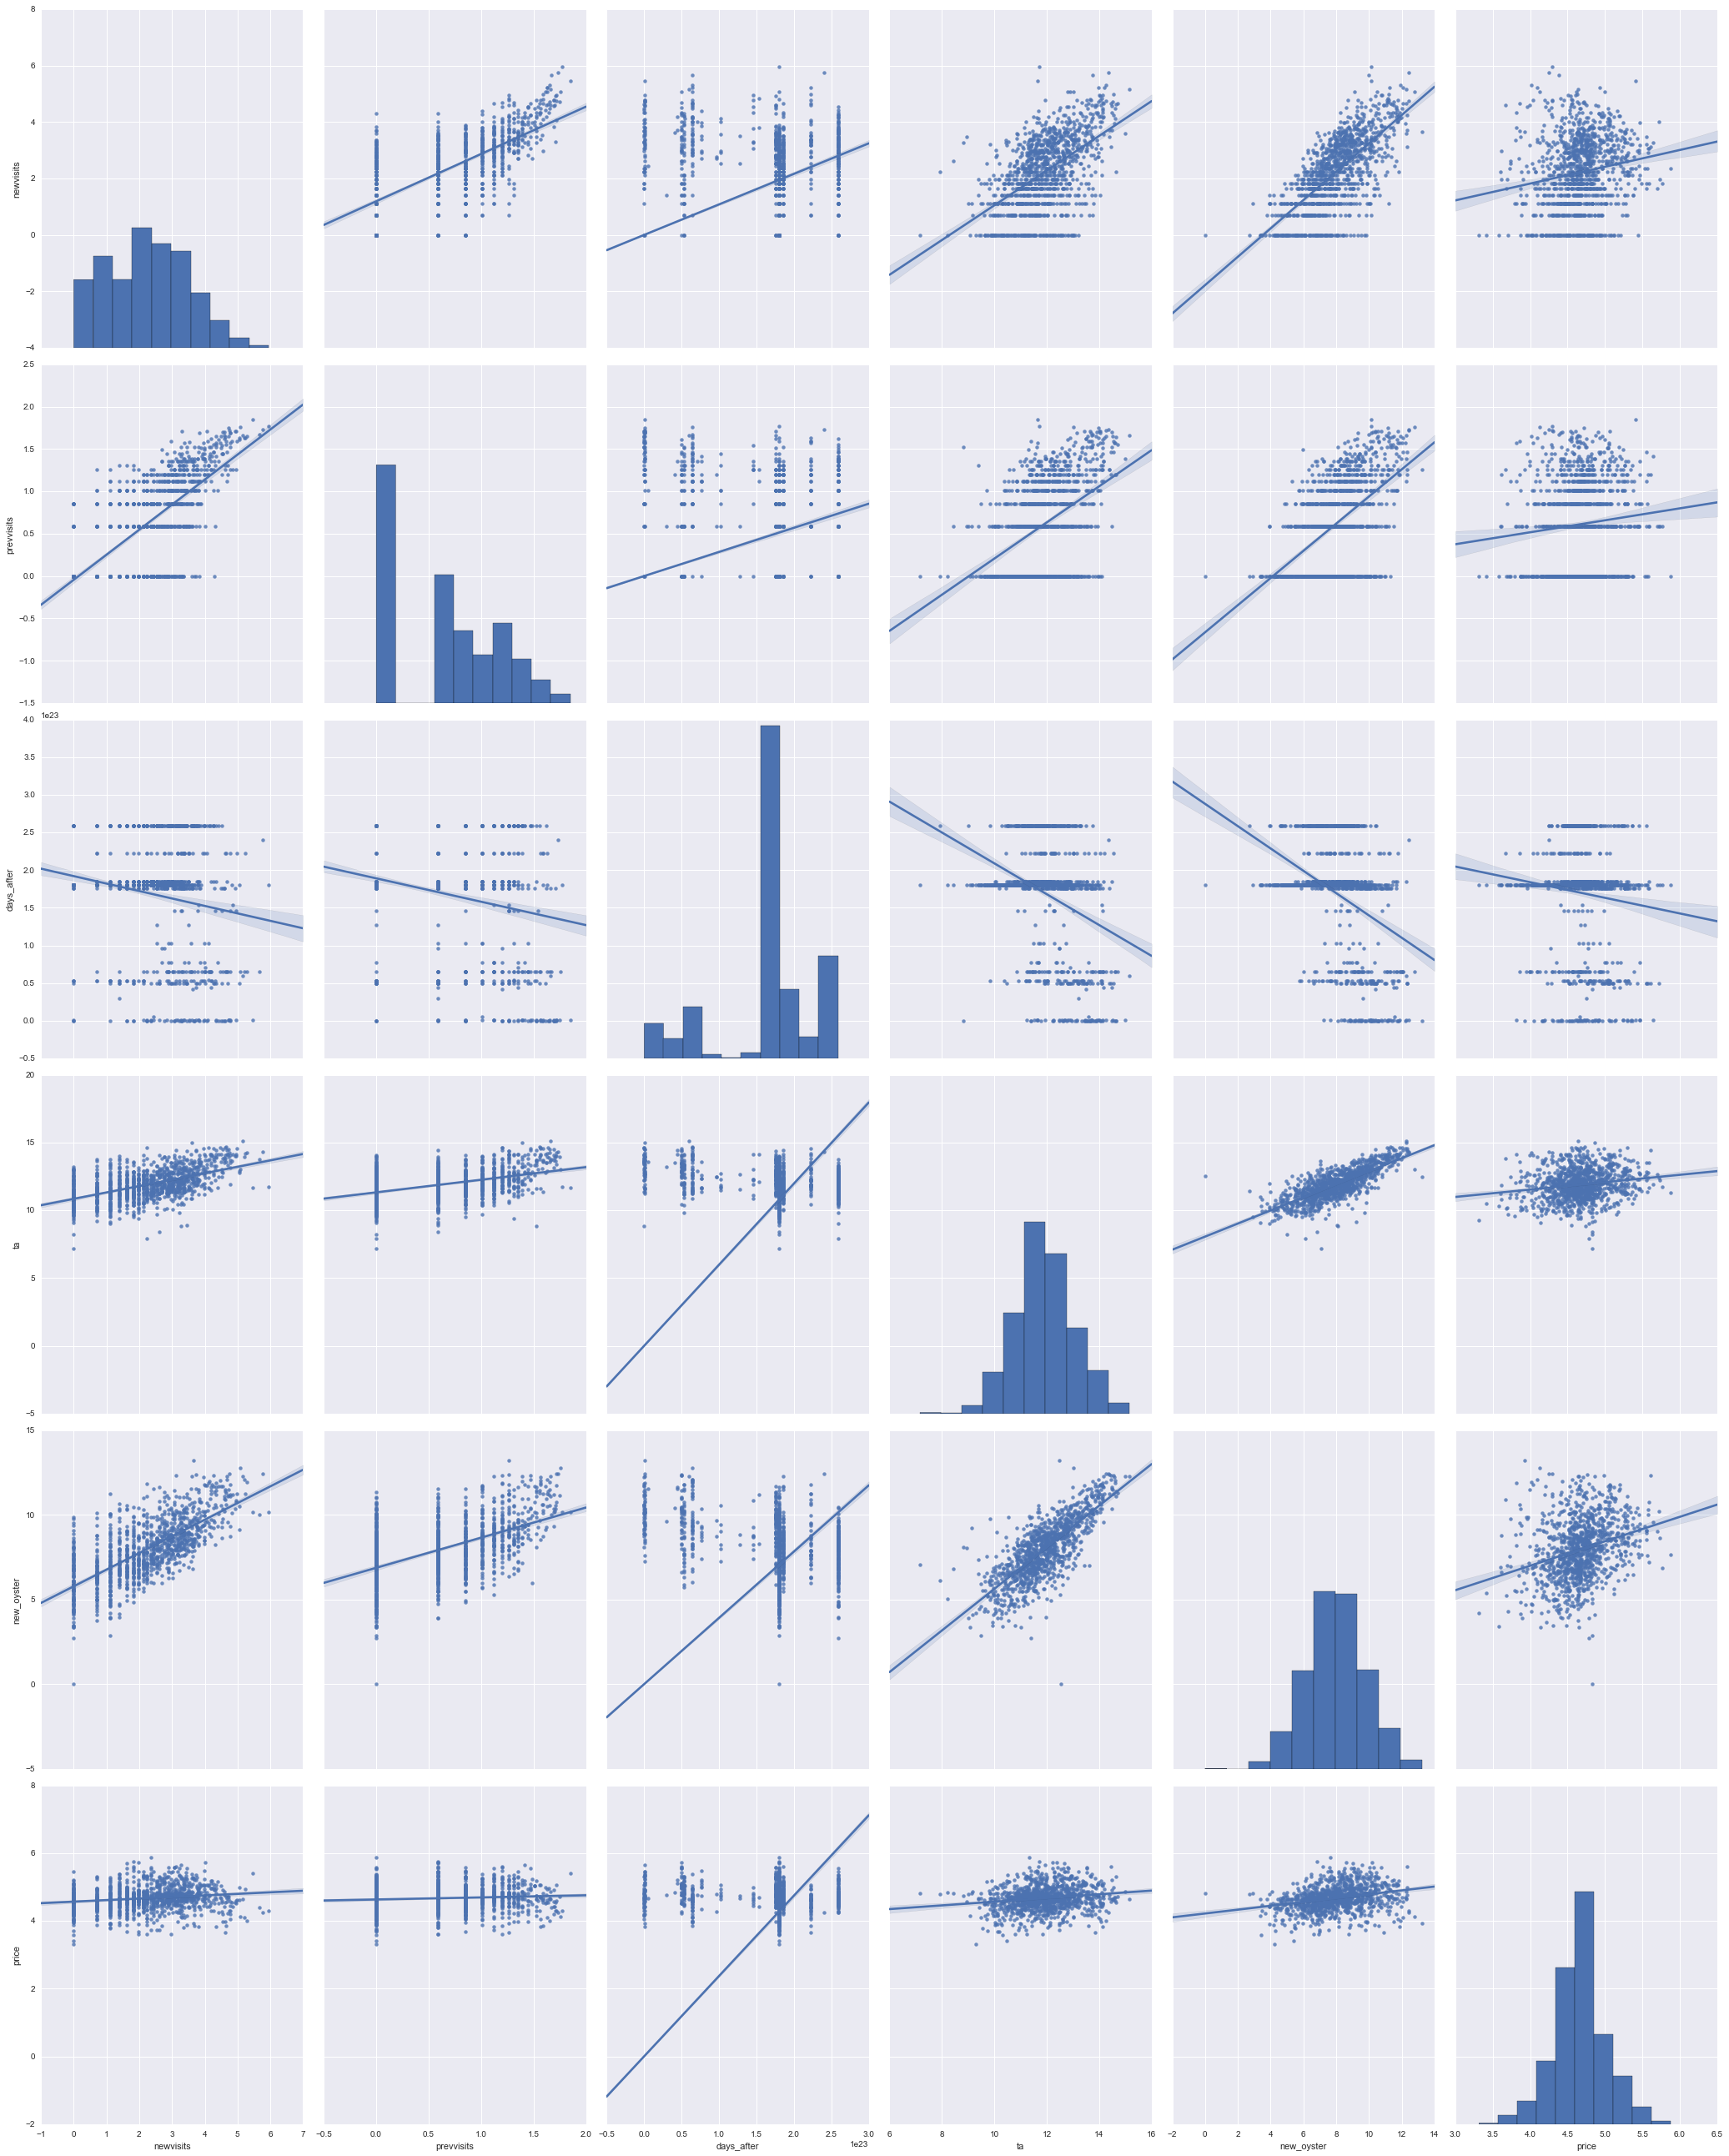

In [64]:
sns.pairplot(transformed[['newvisits','prevvisits','days_after','ta','new_oyster','price']], size = 6, aspect = 0.8, kind = 'reg')

Note that I set the threshold for 'skewed' column flagging so that latitude/longitude would be excluded. These numbers can be large and negative, which we'd have to adjust for with a large offset in order to use a apply transformation. I don't want to have to deal with this yet, so I'm going to transform the others and and have another look before deciding what to do with them.

After transforamtions, heteroskedasticity is clearly reduced in pairwise charts and distributions of numeric variables are more normal. However, discreetness is still a problem for some variables and there are likely non-linear relationships (such as newvistis vs prevvisits) that could be handled by an ensemble tree-based model. If we use a GBM model, we will reap this benefit in addition to getting regularization for free.

## ID categorical variables; create dummy variable cols and remove Nth column

In [80]:
d = data
d["newtrans"] = d["newtrans"].astype('string')
d["location"] = d["location"].astype('string')
d["transmonth"] = d["transmonth"].astype('string')
d["hotel_published_year"] = d["hotel_published_year"].astype('string')
d["rating"] = d["rating"].astype('string')

newtrans_dum = pd.get_dummies(data.newtrans).astype(int)
location_dum = pd.get_dummies(data.location).astype(int)
transmonth_dum = pd.get_dummies(data.transmonth).astype(int)
hotel_published_year_dum = pd.get_dummies(data.hotel_published_year).astype(int)
rating_dum = pd.get_dummies(data.rating).astype(int)

newtrans_dum1 = newtrans_dum.ix[:,:-1]
location_dum1 = location_dum.ix[:,:-1]
transmonth_dum1 = transmonth_dum.ix[:,:-1]
hotel_published_year_dum1 = hotel_published_year_dum.ix[:,:-1]
rating_dum1 = rating_dum.ix[:,:-1]

categorical = pd.concat([newtrans_dum1,location_dum1,transmonth_dum1,hotel_published_year_dum1,rating_dum1],axis = 1)

categorical.columns.tolist()

['2-full',
 '3-full',
 '3-partial',
 'Boston',
 'Caribbean',
 'Hawaii',
 'Las Vegas',
 'Los Angeles',
 'Miami',
 'New York City',
 'San Francisco/Northern Cali',
 '12016',
 '2009.0',
 '2010.0',
 '2011.0',
 '2012.0',
 '2013.0',
 '2014.0',
 '2016.0',
 '10.0',
 '15.0',
 '20.0',
 '25.0',
 '30.0',
 '35.0',
 '40.0',
 '45.0',
 '50.0']

## Combine into final dataset for use in model; try pair plots again

In [108]:
final = pd.concat([categorical,numeric],axis=1)

In [110]:
final.head()


,2-full,3-full,3-partial,Boston,Caribbean,Hawaii,Las Vegas,Los Angeles,Miami,New York City,...,prevvisits,lynewvisits,lyprevvisits,days_after,ta,prev_oyster,new_oyster,price,longitude,latitude
0,0,0,0,0,1,0,0,0,0,0,...,-4.822805,0.753766,1.149895,1.438729e+23,11.335039,11.445701,8.965218,5.977647,-62.832200,17.901600
1,0,0,0,0,0,0,0,0,0,0,...,0.001000,0.001000,-5.276074,1.438729e+23,11.719316,10.905535,7.923511,5.856947,-122.406057,38.493466
2,0,0,0,0,0,0,0,0,0,0,...,0.001000,0.753766,-5.276074,1.438729e+23,12.207896,15.226506,10.320312,5.830799,-122.513300,38.579933
3,0,0,1,0,1,0,0,0,0,0,...,0.001000,1.254920,1.720507,3.957918e+22,12.396963,15.215675,12.594698,5.820091,-77.311165,25.084333
4,0,0,0,0,1,0,0,0,0,0,...,0.001000,1.254920,0.001000,1.438729e+23,12.656618,14.544985,10.922336,5.789247,-105.529365,20.780995


In [43]:
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1)
max_depth_range = range(1, 10)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(rf_grid, param_grid, cv=10)



#grid.fit(pd.DataFrame(final["newvisits"]), pd.DataFrame(final.ix[:,~final.columns.isin(["newvisits"])]))
#grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
#not_transformed = d.ix[:,~d.columns.isin(skewed_cols)]

ValueError: invalid literal for float(): 3-partial